# Introduction


This notebook uses the OpenKMI package to generate the [climate warning stripes](https://showyourstripes.info/s/globe) based on the synoptic data from RMI. 

OpenKMI serves as a wrapper around the WFS service that KMI offers to download both synoptic measurements and data from the automatic weather stations.


# Initialize the package

First load the modules we will use

In [1]:
import matplotlib.pyplot as plt
import pandas as pd   
from openkmi.point_obs import Synop

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap

plt.rcParams['font.family'] = 'Monospace'

Then initialize the package

In [2]:
kmi = Synop()

# Inspect the available stations

You can use OpenKMI to get an overview of all stations where you can collect the data for

In [3]:
df_stations = kmi.get_stations()
print(f'There are {df_stations.shape[0]} stations available')

There are 22 stations available


In [4]:
df_stations

,code,the_geom,altitude,name,date_begin,date_end
0,6490,POINT (50.478615 5.909864),482.0,SPA (AERODROME),1952-01-01T00:00:00,NaN
1,6476,POINT (50.038875 5.403753),557.0,SAINT-HUBERT,1952-01-01T00:00:00,NaN
2,6414,POINT (50.90398 3.121692),24.8,BEITEM,2003-08-01T07:00:00,NaN
3,6418,POINT (51.347375 3.201846),12.1,ZEEBRUGGE,2005-12-01T00:00:00,NaN
4,6438,POINT (51.324802 4.363798),4.0,STABROEK,2012-08-05T00:00:00,NaN
5,6446,POINT (50.796862 4.357871),100.6,UCCLE-UKKEL,2001-08-23T00:00:00,2003-12-09T08:00:00
6,6447,POINT (50.796862 4.357871),100.6,UCCLE-UKKEL,2003-12-01T00:00:00,NaN
7,6477,POINT (50.915458 5.450296),39.3,DIEPENBEEK,2004-06-29T00:00:00,NaN
8,6478,POINT (50.645282 5.458738),178.0,BIERSET,1952-01-01T00:00:00,NaN
9,6439,POINT (51.075125 4.524608),8.3,SINT-KATELIJNE-WAVER,2007-10-22T00:00:00,NaN


# Inspect the available parameters

Let's see what data is in the wfs and what data we can use to filter upon.

In [5]:
kmi.get_parameters()

{'code': 'int',
 'timestamp': 'dateTime',
 'precip_quantity': 'decimal',
 'precip_range': 'decimal',
 'temp': 'decimal',
 'temp_min': 'decimal',
 'temp_max': 'decimal',
 'temp_grass_min': 'decimal',
 'wind_speed': 'decimal',
 'wind_speed_unit': 'int',
 'wind_direction': 'decimal',
 'wind_peak_speed': 'decimal',
 'humidity_relative': 'decimal',
 'weather_current': 'int',
 'pressure': 'decimal',
 'pressure_station_level': 'decimal',
 'sun_duration_24hours': 'decimal',
 'short_wave_from_sky_24hours': 'decimal',
 'cloudiness': 'decimal'}

# Generate stripes

The code below generates the warning stripes for a number of stations with long time series.

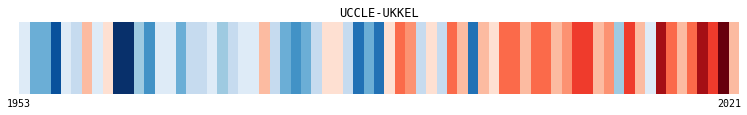

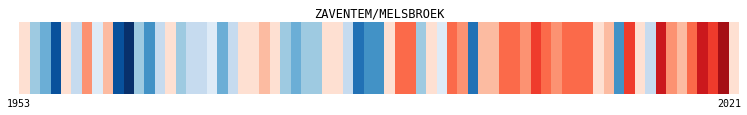

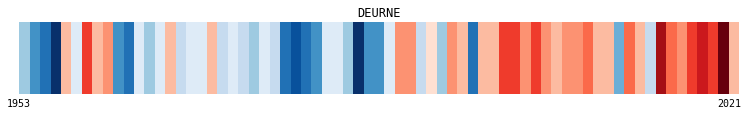

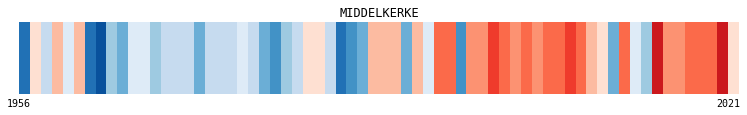

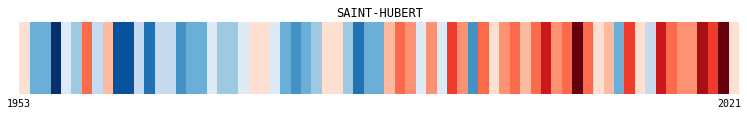

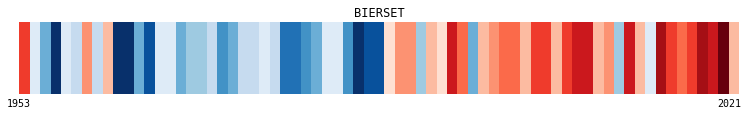

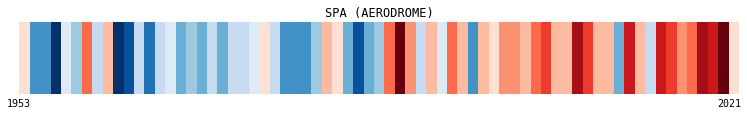

In [9]:
for station_code in ['6447', '6451', '6450', '6407', '6476', '6478', '6490']:
    # Get the data
    df_r = kmi.get_data(station_code, parameter_list=['temp'])
    # From the data it seems that in the past there was not always data for every hour but once every 3 hours.
    # Therefore we filter the data to avoid a bias due to this.
    # Note that there are still missing values in the data and the number of observations per year is not alwasy equal but for the general picture this should be enough.
    df_r = df_r[df_r.index.hour.isin([0,3,6,9,12,15,18,21])]
    
    # Take the average value per year. Leave out the first and last year as they are generally incomplete
    temp_year = df_r.dropna().groupby(df_r.dropna().index.year).mean().iloc[1:-1]

    # This part of the code comes from the matplotlib doc:
    # https://matplotlib.org/matplotblog/posts/warming-stripes/
    # and has only been slightly adapted
    FIRST = temp_year.index[0]
    LAST = temp_year.index[-1]  # inclusive
    FIRST_REFERENCE = FIRST
    LAST_REFERENCE = LAST
    LIM = 2

    anomaly = temp_year.dropna()
    reference = anomaly.loc[FIRST_REFERENCE:LAST_REFERENCE].mean()['temp']

    cmap = ListedColormap([
        '#08306b', '#08519c', '#2171b5', '#4292c6',
        '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
        '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
        '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
    ])

    fig = plt.figure(figsize=(10, 1))
    
    ax = fig.add_axes([0, 0, 1, 1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.tick_params(axis='x', which=u'both',length=0)

    col = PatchCollection([
        Rectangle((y, 0), 1, 1)
        for y in range(FIRST, LAST + 1)
    ])

    col.set_array(anomaly['temp'])
    col.set_cmap(cmap)
    col.set_clim(reference - LIM, reference + LIM)
    ax.add_collection(col)

    ax.set_ylim(0, 1)
    ax.set_xticks([FIRST, LAST])
    ax.set_xticklabels([FIRST, LAST])
    ax.set_xlim(FIRST, LAST + 1)
    ax.set_title(df_stations.loc[df_stations['code'] == station_code, 'name'].values[0])